<a href="https://colab.research.google.com/github/josedavid2101/Image_Synthesis_Diffusion_Model/blob/main/DDPM_microstructures_1chanel_64.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Generating microstructure images with DDPMs using PyTorch

Generative models known as Denoise Diffusion Probabilistic Models (DDPMs) are applied for the purification of noisy digital photos. Through exposure to a database of both noise-filled and clean images, these models master the skill of creating noise-reduced renditions of input images. DDPMs are widely used across several fields, including photography and medical imaging, where noise elimination is key for enhancing image clarity and comprehension.

This Google Colab notebook employs a DDPM to produce artificial representations of metals' inner composition. Training is carried out utilizing images of nickel microstructures derived from accurate simulations. The artificial microstructures generated through this process will pave the way for more streamlined material optimization.

## Imports and Definitions

In [2]:
# Import of libraries
import random
import imageio
import numpy as np
from argparse import ArgumentParser

from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset

from torchvision.transforms import Compose, ToTensor, Lambda

import os
import pandas as pd
from PIL import Image

import pdb

# Setting reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Definitions
STORE_PATH_MNIST = f"ddpm_model_mnist.pt"
STORE_PATH_FASHION = f"ddpm_model_fashion.pt"

## Execution options

- `batch_size`, `n_epochs` and `lr` are your typical training hyper-parameters. Notice that `lr=0.001` is the hyper-parameter used by the authors.

In [3]:
batch_size = 9
n_epochs = 20
lr = 0.001

# Utility functions

Following are two utility functions: `show_images` allows to display images in a square-like pattern with a custom title, while `show_fist_batch` simply shows the images in the first batch of a DataLoader object.

In [4]:
def show_images(images, title=""):
    """Shows the provided images as sub-pictures in a square"""

    # Converting images to CPU numpy arrays
    if type(images) is torch.Tensor:
        images = images.detach().cpu().numpy()

    # Defining number of rows and columns
    fig = plt.figure(figsize=(10, 10))
    rows = int(len(images) ** (1 / 2))
    cols = round(len(images) / rows)

    # Populating figure with sub-plots
    idx = 0
    for r in range(rows):
        for c in range(cols):
            fig.add_subplot(rows, cols, idx + 1)

            if idx < len(images):
                plt.imshow(images[idx][0], cmap="gray")
                idx += 1
    fig.suptitle(title, fontsize=30)

    # Showing the figure
    plt.show()

In [5]:
def show_first_batch(loader):
    for batch in loader:
        show_images(batch, "Images in the first batch")
        break

## Loading data
We employ a dataset of microstructure images that were produced by executing authentic simulations, following the methodologies detailed in https://doi.org/10.1016/j.commatsci.2022.111879. Our aim is to generate novel samples from random Gaussian noise. IMPORTANT: During image normalization, it's critical to use a range of [-1,1], rather than the typical [0,1] range. This is due to the fact that the DDPM network predicts noises, which follow a normal distribution, throughout the denoising process.

In [6]:
# Class to load microstructure data

class microstructureDataset(Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, csv_file, root_dir, transform=None):
        'Initialization'
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.annotations)

    def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        if self.transform:
            image = self.transform(image)

        return (image)

In [12]:
dir="/content/drive/MyDrive/LM_64x64_vor_GB"
# dir = "/home/josens/DDPM/Images" #Supercomputer directory
file_csv="mics_64_120_1000.csv"

In [13]:
# Loading the data (converting each image into a tensor and normalizing between [-1, 1])
transform = Compose([
    ToTensor(),
    Lambda(lambda x: (x - 0.5) * 2)]
)
# Load Data
dataset = microstructureDataset(
    csv_file=file_csv,
    root_dir=dir,
    transform=transform,
)
loader = DataLoader(dataset, batch_size, shuffle=True)

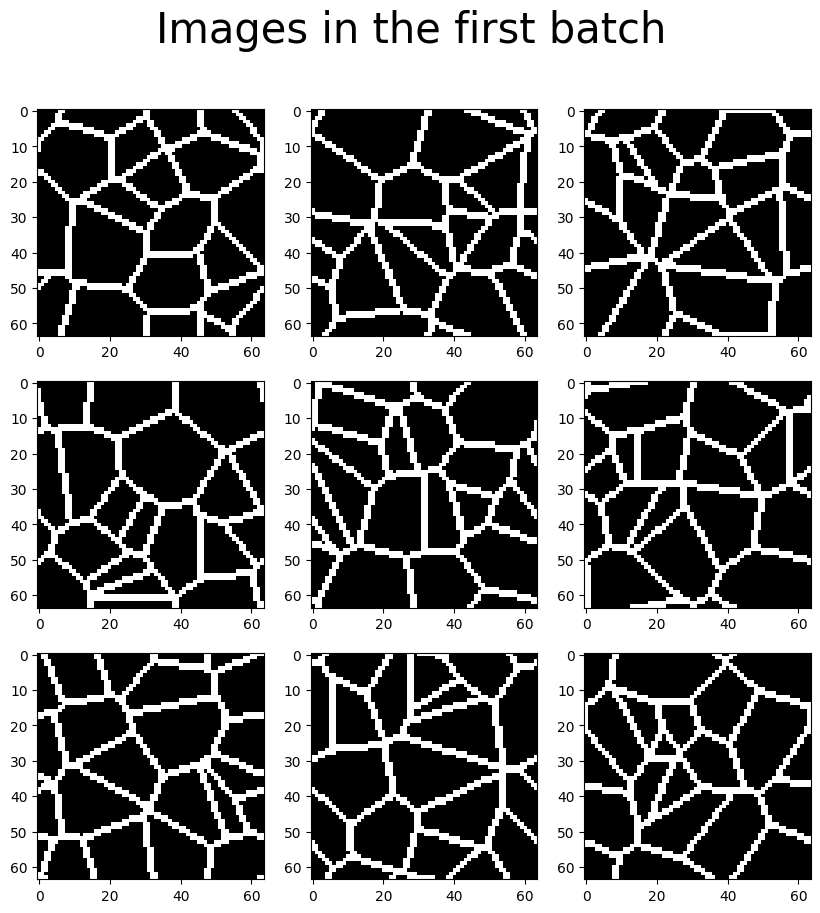

In [14]:
# Optionally, show a batch of regular images
show_first_batch(loader)

## Getting device

If you are running this codebook from Google Colab, make sure you are using a GPU runtime. For non-pro users, typically a *Tesla T4* GPU is provided.

In [15]:
# Getting device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}\t" + (f"{torch.cuda.get_device_name(0)}" if torch.cuda.is_available() else "CPU"))

Using device: cuda	Tesla T4


# Defining the DDPM module

We're now ready to construct a DDPM PyTorch module. Given that the DDPM scheme does not inherently depend on the model structure utilized in each denoising phase, we're designing a comprehensive model that is assembled using a network parameter, along with:

    n_steps: The number of diffusion steps, represented by $T$;
    min_beta: The value of the first $\beta_t$, specifically $\beta_1$;
    max_beta: The value of the last $\beta_t$, which is $\beta_T$;
    device: The apparatus on which the model is operated;
    image_chw: A tuple that includes the dimensionality of the images.

The forward procedure of DDPMs holds a beneficial characteristic: There's no need to gradually incorporate noise in a step-by-step manner, but we can directly leap to whichever step $t$ we desire using coefficients $\alpha_bar$.

As for the backward method, we merely allow the network to carry out the task.

It's important to note that in this particular implementation, $t$ is considered to be a (N, 1) tensor, with N being the number of images in tensor x. Consequently, we cater for varying time-steps across multiple images.

In [16]:
# DDPM class
class MyDDPM(nn.Module):
    def __init__(self, network, n_steps=200, min_beta=10 ** -4, max_beta=0.02, device=None, image_chw=(1, 64, 64)):
        super(MyDDPM, self).__init__()
        self.n_steps = n_steps
        self.device = device
        self.image_chw = image_chw
        self.network = network.to(device)
        self.betas = torch.linspace(min_beta, max_beta, n_steps).to(
            device)  # Number of steps is typically in the order of thousands
        self.alphas = 1 - self.betas
        self.alpha_bars = torch.tensor([torch.prod(self.alphas[:i + 1]) for i in range(len(self.alphas))]).to(device)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(self.device)

        noisy = a_bar.sqrt().reshape(n, 1, 1, 1) * x0 + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)

## Visualizing forward and backward

Having defined the high-level operation of a DDPM model, we are now in a position to lay out some related utility functions. Notably, the forward process, which remains unaffected by the denoising network, will be demonstrated with the `show_forward` method.

The `generate_new_images` method is used to conduct the backward pass and create new images. However, for this method, we will invest additional effort to ensure it generates a GIF image. As outlined in the paper by Ho et al. (https://arxiv.org/pdf/2006.11239.pdf), two alternatives are proposed for $\sigma_t^2$:

  - $\sigma_t^2$ = $\beta_t$
  - $\sigma_t^2$ = $\frac{1 - \bar{\alpha_{t-1}}}{1 - \bar{\alpha_{t}}} - -  \beta_t$

In our implementation, either can be selected with just a few modifications in the comments. However, both terms are generally equivalent and only a minor difference is discernible. For the sake of simplicity, I default to the first option.

In [17]:
def show_forward(ddpm, loader, device):
    # Showing the forward process
    for batch in loader:
        imgs = batch

        show_images(imgs, "Original images")

        for percent in [0.25, 0.5, 0.75, 1]:
            show_images(
                ddpm(imgs.to(device),
                     [int(percent * ddpm.n_steps) - 1 for _ in range(len(imgs))]),
                f"DDPM Noisy images {int(percent * 100)}%"
            )
        break

In [18]:
def generate_new_images(ddpm, n_samples=16, device=None, frames_per_gif=100, gif_name="sampling.gif", c=1, h=64, w=64):
    """Given a DDPM model, a number of samples to be generated and a device, returns some newly generated samples"""
    frame_idxs = np.linspace(0, ddpm.n_steps, frames_per_gif).astype(np.uint)
    frames = []

    with torch.no_grad():
        if device is None:
            device = ddpm.device

        # Starting from random noise
        x = torch.randn(n_samples, c, h, w).to(device)

        for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
            # Estimating noise to be removed
            time_tensor = (torch.ones(n_samples, 1) * t).to(device).long()
            eta_theta = ddpm.backward(x, time_tensor)

            alpha_t = ddpm.alphas[t]
            alpha_t_bar = ddpm.alpha_bars[t]

            # Partially denoising the image
            x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

            if t > 0:
                z = torch.randn(n_samples, c, h, w).to(device)

                # Option 1: sigma_t squared = beta_t
                beta_t = ddpm.betas[t]
                sigma_t = beta_t.sqrt()

                # Option 2: sigma_t squared = beta_tilda_t
                # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
                # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
                # sigma_t = beta_tilda_t.sqrt()

                # Adding some more noise like in Langevin Dynamics fashion
                x = x + sigma_t * z

            # Adding frames to the GIF
            if idx in frame_idxs or t == 0:
                # Putting digits in range [0, 255]
                normalized = x.clone()
                for i in range(len(normalized)):
                    normalized[i] -= torch.min(normalized[i])
                    normalized[i] *= 255 / torch.max(normalized[i])

                # Reshaping batch (n, c, h, w) to be a (as much as it gets) square frame
                frame = einops.rearrange(normalized, "(b1 b2) c h w -> (b1 h) (b2 w) c", b1=int(n_samples ** 0.5))
                frame = frame.cpu().numpy().astype(np.uint8)

                # Rendering frame
                frames.append(frame)

    # Storing the gif
    with imageio.get_writer(gif_name, mode="I") as writer:
        for idx, frame in enumerate(frames):
            writer.append_data(frame)
            if idx == len(frames) - 1:
                for _ in range(frames_per_gif // 3):
                    writer.append_data(frames[-1])
    return x

# UNet architecture

The next step is to define an architecture that will take on the role of denoising - then we're all set. Although this seems straightforward in theory, it's crucial to condition our model accurately with the temporal information.

Let's recall that the only term of the loss function we're truly concerned with is $||\epsilon - \epsilon_\theta(\sqrt{\bar{\alpha}t}x_0 + \sqrt{1 - \bar{\alpha}t}\epsilon, t)||^2$, where $\epsilon$ denotes some random noise and $\epsilon\theta$ signifies the model's noise prediction. Now, $\epsilon\theta$ is a function of both $x$ and $t$, and we don't wish to have a unique model for every denoising step (which would mean thousands of independent models). Instead, we aim for a single model that takes in the image $x$ and a scalar value indicating the timestep $t$ as inputs.

In practical terms, we employ a sinusoidal embedding (the sinusoidal_embedding function) that maps each time-step to a time_emb_dim dimension. These time embeddings are further transformed with some time-embedding MLPs (the _make_te function) and added to tensors within the network in a channel-wise fashion.

In [19]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * wk[:,::2])
    embedding[:,1::2] = torch.cos(t * wk[:,::2])

    return embedding

In [20]:
class MyBlock(nn.Module):
    def __init__(self, shape, in_c, out_c, kernel_size=3, stride=1, padding=1, activation=None, normalize=True):
        super(MyBlock, self).__init__()
        self.ln = nn.LayerNorm(shape)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size, stride, padding)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.ln(x) if self.normalize else x
        out = self.conv1(out)
        out = self.activation(out)
        out = self.conv2(out)
        out = self.activation(out)
        return out

In [21]:
# exact output size can be also specified as an argument
input = torch.randn(1, 10, 12, 12)
downsample = nn.Conv2d(10, 10, 4, 2, 1)
upsample = nn.ConvTranspose2d(10, 10, 4, 2, 1)
h = downsample(input)
output = upsample(h, output_size=input.size())
h.size(), output.size()




(torch.Size([1, 10, 6, 6]), torch.Size([1, 10, 12, 12]))

In [22]:
class MyUNet(nn.Module):
    def __init__(self, n_steps=1000, time_emb_dim=100):
        super(MyUNet, self).__init__()

        # Sinusoidal embedding
        self.time_embed = nn.Embedding(n_steps, time_emb_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
        self.time_embed.requires_grad_(False)

        # First half
        self.te1 = self._make_te(time_emb_dim, 1)
        self.b1 = nn.Sequential(
            MyBlock((1, 64, 64), 1, 10),
            MyBlock((10, 64, 64), 10, 10),
            MyBlock((10, 64, 64), 10, 10)
        )
        self.down1 = nn.Conv2d(10, 10, 4, 2, 1)

        self.te2 = self._make_te(time_emb_dim, 10)
        self.b2 = nn.Sequential(
            MyBlock((10, 32, 32), 10, 20),
            MyBlock((20, 32, 32), 20, 20),
            MyBlock((20, 32, 32), 20, 20)
        )
        self.down2 = nn.Conv2d(20, 20, 4, 2, 1)

        self.te3 = self._make_te(time_emb_dim, 20)
        self.b3 = nn.Sequential(
            MyBlock((20, 16, 16), 20, 40),
            MyBlock((40, 16, 16), 40, 40),
            MyBlock((40, 16, 16), 40, 40)
        )
        self.down3 = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1),
            nn.SiLU(),
            nn.Conv2d(40, 40, 4, 2, 1)
        )

        # Bottleneck
        self.te_mid = self._make_te(time_emb_dim, 40)
        self.b_mid = nn.Sequential(
            MyBlock((40, 7, 7), 40, 20),
            MyBlock((20, 7, 7), 20, 20),
            MyBlock((20, 7, 7), 20, 40)
        )

        # Second half
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 3, 1)
        )

        self.te4 = self._make_te(time_emb_dim, 80)
        self.b4 = nn.Sequential(
            MyBlock((80, 16, 16), 80, 40),
            MyBlock((40, 16, 16), 40, 20),
            MyBlock((20, 16, 16), 20, 20)
        )

        self.up2 = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.te5 = self._make_te(time_emb_dim, 40)
        self.b5 = nn.Sequential(
            MyBlock((40, 32, 32), 40, 20),
            MyBlock((20, 32, 32), 20, 10),
            MyBlock((10, 32, 32), 10, 10)
        )

        self.up3 = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.te_out = self._make_te(time_emb_dim, 20)
        self.b_out = nn.Sequential(
            MyBlock((20, 64, 64), 20, 10),
            MyBlock((10, 64, 64), 10, 10),
            MyBlock((10, 64, 64), 10, 10, normalize=False)
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x, t):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        t = self.time_embed(t)
        n = len(x)
        out1 = self.b1(x + self.te1(t).reshape(n, -1, 1, 1))  # (N, 10, 28, 28)
        out2 = self.b2(self.down1(out1) + self.te2(t).reshape(n, -1, 1, 1))  # (N, 20, 14, 14)
        out3 = self.b3(self.down2(out2) + self.te3(t).reshape(n, -1, 1, 1))  # (N, 40, 7, 7)

        out_mid = self.b_mid(self.down3(out3) + self.te_mid(t).reshape(n, -1, 1, 1))  # (N, 40, 3, 3)


        #pdb.set_trace()
        #print(out3.shape)
        #print(out_mid.shape)
        #aaa = self.up1(out_mid)
        #print(aaa.shape)

        out4 = torch.cat((out3, self.up1(out_mid)), dim=1)  # (N, 80, 7, 7)
        out4 = self.b4(out4 + self.te4(t).reshape(n, -1, 1, 1))  # (N, 20, 7, 7)

        out5 = torch.cat((out2, self.up2(out4)), dim=1)  # (N, 40, 14, 14)
        out5 = self.b5(out5 + self.te5(t).reshape(n, -1, 1, 1))  # (N, 10, 14, 14)

        out = torch.cat((out1, self.up3(out5)), dim=1)  # (N, 20, 28, 28)
        out = self.b_out(out + self.te_out(t).reshape(n, -1, 1, 1))  # (N, 1, 28, 28)

        out = self.conv_out(out)

        return out

    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out),
            nn.SiLU(),
            nn.Linear(dim_out, dim_out)
        )
print("Unet")

Unet


# Instantiating the model

The next steps are to create an instance of the model, and then craft the customary code that sets up a training loop for our model. After the training is completed, we'll put the model's generative abilities to the test.

In [23]:
# Defining model
n_steps, min_beta, max_beta = 1000, 10 ** -4, 0.02  # Originally used by the authors
ddpm = MyDDPM(MyUNet(n_steps), n_steps=n_steps, min_beta=min_beta, max_beta=max_beta, device=device)

In [24]:
sum([p.numel() for p in ddpm.parameters()])

1323396

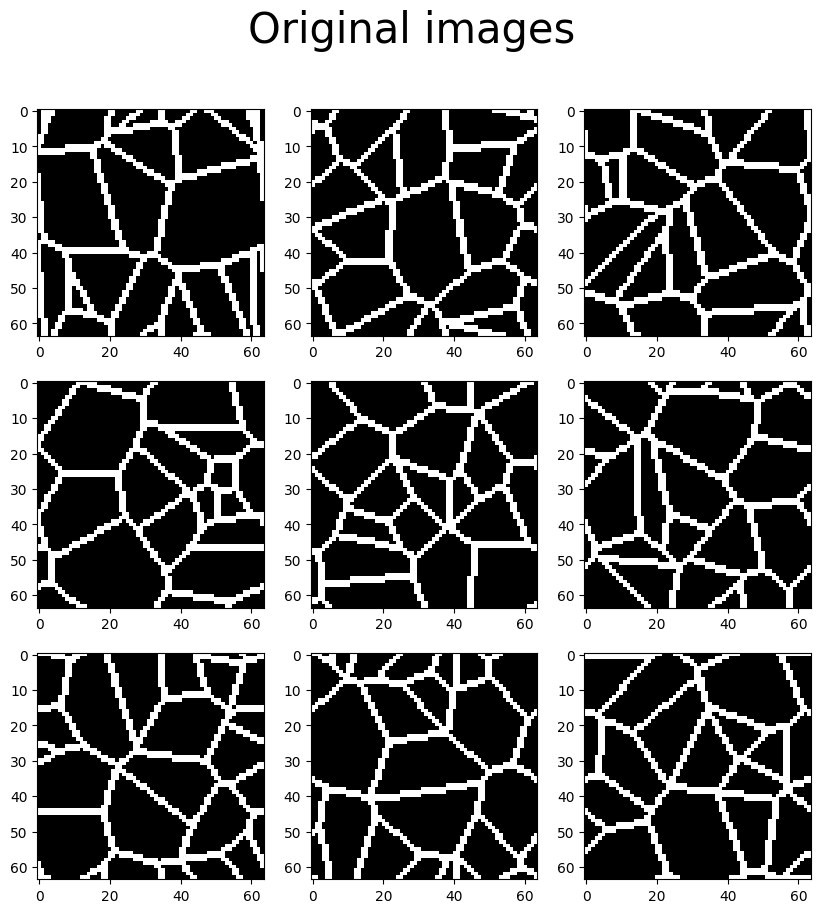

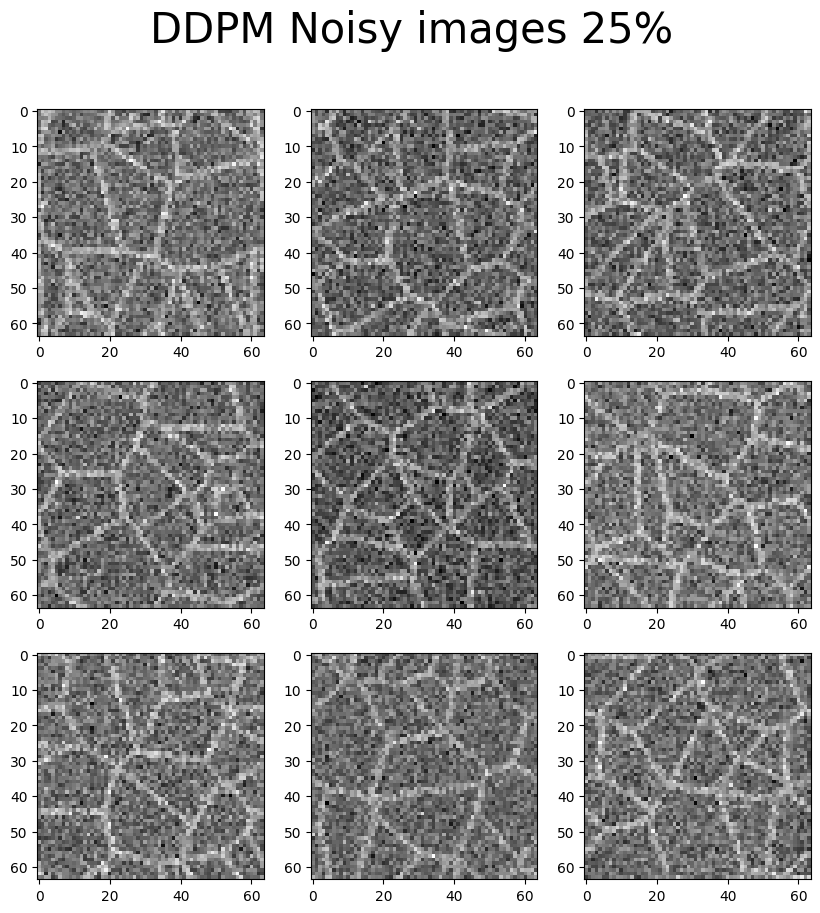

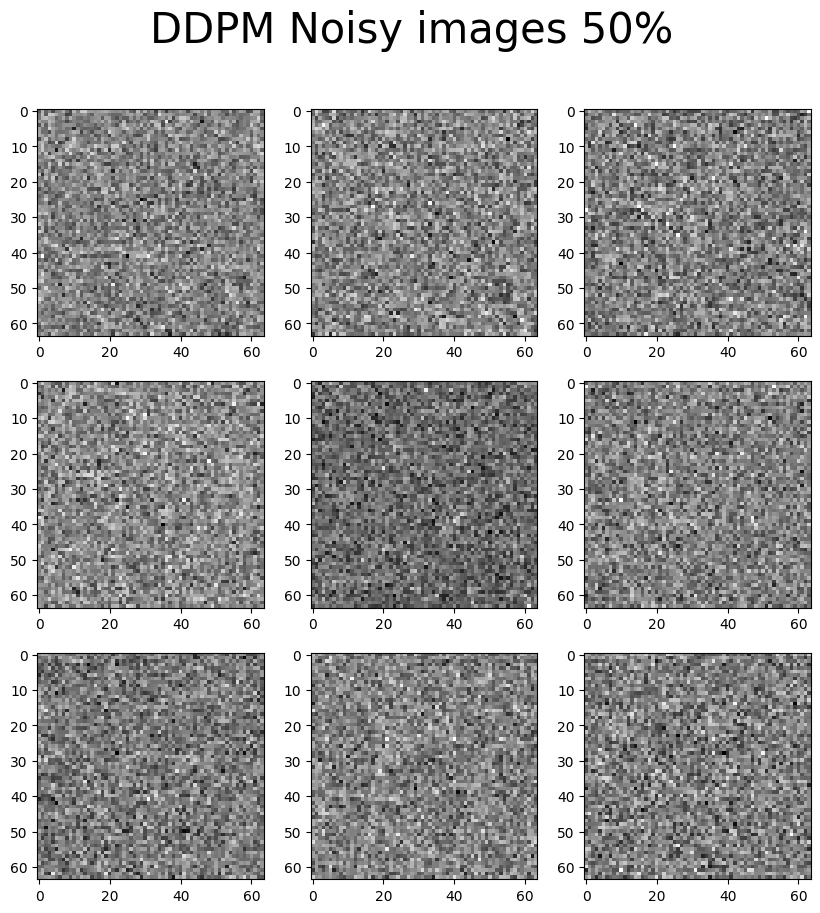

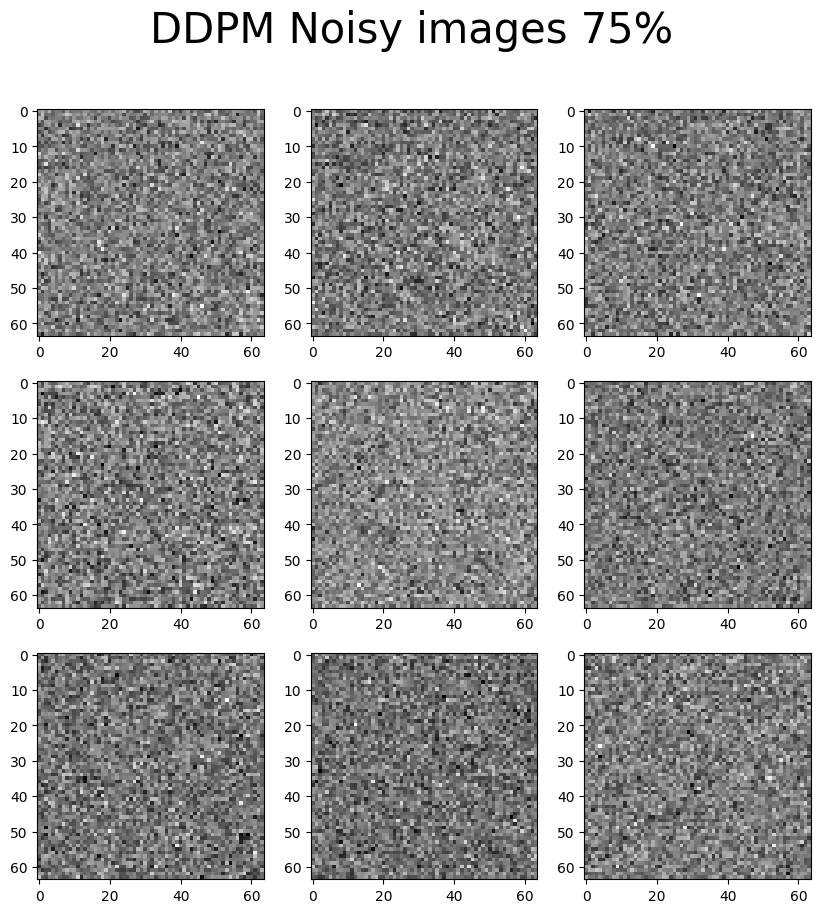

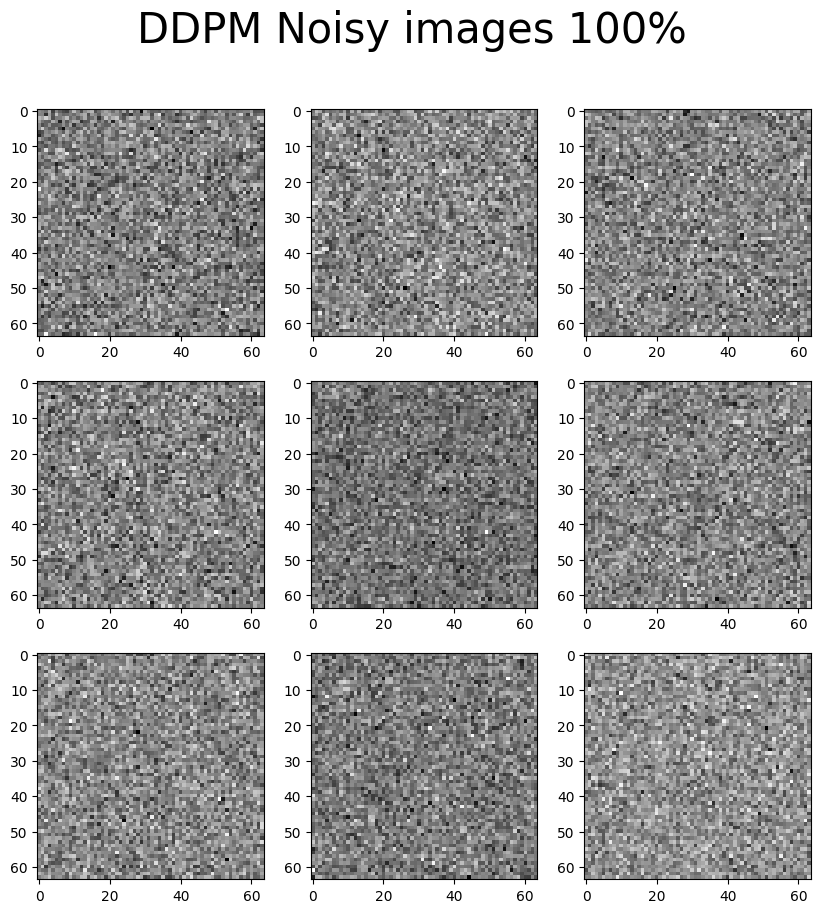

In [25]:
# Optionally, show the diffusion (forward) process
show_forward(ddpm, loader, device)

In [ ]:
# Optionally, show the denoising (backward) process

# generated = generate_new_images(ddpm, gif_name="before_training.gif")
# show_images(generated, "Images generated before training")

# Training loop

The training loop is relatively straightforward. For every batch from our dataset, we execute the forward process on the batch. To ensure enhanced training stability, we utilize different timesteps $t$ for each of the N images in our (N, C, H, W) batch tensor. The incorporated noise is a (N, C, H, W) tensor denoted by $\epsilon$ After we have procured the noisy images, we aim to predict $\epsilon$ from them using our network. The optimization is carried out using a straightforward Mean-Squared Error (MSE) loss.

In [26]:
def training_loop(ddpm, loader, n_epochs, optim, device, display=False, store_path="ddpm_model.pt"):
    mse = nn.MSELoss()
    best_loss = float("inf")
    n_steps = ddpm.n_steps

    for epoch in tqdm(range(n_epochs), desc=f"Training progress", colour="#00ff00"):
        epoch_loss = 0.0
        for step, batch in enumerate(tqdm(loader, leave=False, desc=f"Epoch {epoch + 1}/{n_epochs}", colour="#005500")):
            # Loading data
            x0 = batch.to(device)
            n = len(x0)

            # Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
            eta = torch.randn_like(x0).to(device)
            t = torch.randint(0, n_steps, (n,)).to(device)

            # Computing the noisy image based on x0 and the time-step (forward process)
            noisy_imgs = ddpm(x0, t, eta)

            # Getting model estimation of noise based on the images and the time-step
            eta_theta = ddpm.backward(noisy_imgs, t.reshape(n, -1))

            # Optimizing the MSE between the noise plugged and the predicted noise
            loss = mse(eta_theta, eta)
            optim.zero_grad()
            loss.backward()
            optim.step()

            epoch_loss += loss.item() * len(x0) / len(loader.dataset)

        # Display images generated at this epoch
        if display:
            show_images(generate_new_images(ddpm, device=device), f"Images generated at epoch {epoch + 1}")

        log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

        # Storing the model
        if best_loss > epoch_loss:
            best_loss = epoch_loss
            torch.save(ddpm.state_dict(), store_path)
            log_string += " --> Best model ever (stored)"

        print(log_string)

In [31]:
# Training
store_path = "ddpm_mics.pt"
n_epochs = 100
training_loop(ddpm, loader, n_epochs, optim=Adam(ddpm.parameters(), lr), device=device, store_path=store_path)

Training progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 1: 0.064 --> Best model ever (stored)


Epoch 2/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 2: 0.053 --> Best model ever (stored)


Epoch 3/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 3: 0.057


Epoch 4/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 4: 0.056


Epoch 5/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 5: 0.058


Epoch 6/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 6: 0.051 --> Best model ever (stored)


Epoch 7/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 7: 0.048 --> Best model ever (stored)


Epoch 8/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 8: 0.053


Epoch 9/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 9: 0.050


Epoch 10/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 10: 0.051


Epoch 11/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 11: 0.044 --> Best model ever (stored)


Epoch 12/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 12: 0.046


Epoch 13/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 13: 0.039 --> Best model ever (stored)


Epoch 14/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 14: 0.042


Epoch 15/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 15: 0.045


Epoch 16/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 16: 0.043


Epoch 17/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 17: 0.050


Epoch 18/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 18: 0.049


Epoch 19/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 19: 0.045


Epoch 20/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 20: 0.043


Epoch 21/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 21: 0.046


Epoch 22/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 22: 0.044


Epoch 23/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 23: 0.041


Epoch 24/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 24: 0.043


Epoch 25/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 25: 0.040


Epoch 26/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 26: 0.045


Epoch 27/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 27: 0.038 --> Best model ever (stored)


Epoch 28/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 28: 0.038 --> Best model ever (stored)


Epoch 29/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 29: 0.041


Epoch 30/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 30: 0.047


Epoch 31/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 31: 0.041


Epoch 32/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 32: 0.037 --> Best model ever (stored)


Epoch 33/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 33: 0.040


Epoch 34/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 34: 0.037


Epoch 35/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 35: 0.049


Epoch 36/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 36: 0.038


Epoch 37/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 37: 0.042


Epoch 38/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 38: 0.037


Epoch 39/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 39: 0.042


Epoch 40/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 40: 0.044


Epoch 41/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 41: 0.037


Epoch 42/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 42: 0.042


Epoch 43/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 43: 0.038


Epoch 44/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 44: 0.038


Epoch 45/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 45: 0.036 --> Best model ever (stored)


Epoch 46/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 46: 0.037


Epoch 47/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 47: 0.036


Epoch 48/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 48: 0.036


Epoch 49/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 49: 0.035 --> Best model ever (stored)


Epoch 50/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 50: 0.041


Epoch 51/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 51: 0.033 --> Best model ever (stored)


Epoch 52/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 52: 0.035


Epoch 53/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 53: 0.038


Epoch 54/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 54: 0.036


Epoch 55/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 55: 0.032 --> Best model ever (stored)


Epoch 56/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 56: 0.038


Epoch 57/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 57: 0.037


Epoch 58/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 58: 0.034


Epoch 59/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 59: 0.033


Epoch 60/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 60: 0.037


Epoch 61/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 61: 0.035


Epoch 62/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 62: 0.036


Epoch 63/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 63: 0.029 --> Best model ever (stored)


Epoch 64/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 64: 0.031


Epoch 65/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 65: 0.035


Epoch 66/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 66: 0.034


Epoch 67/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 67: 0.032


Epoch 68/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 68: 0.037


Epoch 69/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 69: 0.041


Epoch 70/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 70: 0.039


Epoch 71/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 71: 0.034


Epoch 72/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 72: 0.032


Epoch 73/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 73: 0.032


Epoch 74/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 74: 0.032


Epoch 75/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 75: 0.034


Epoch 76/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 76: 0.035


Epoch 77/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 77: 0.033


Epoch 78/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 78: 0.035


Epoch 79/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 79: 0.032


Epoch 80/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 80: 0.030


Epoch 81/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 81: 0.031


Epoch 82/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 82: 0.031


Epoch 83/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 83: 0.031


Epoch 84/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 84: 0.030


Epoch 85/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 85: 0.030


Epoch 86/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 86: 0.028 --> Best model ever (stored)


Epoch 87/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 87: 0.033


Epoch 88/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 88: 0.029


Epoch 89/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 89: 0.036


Epoch 90/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 90: 0.030


Epoch 91/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 91: 0.029


Epoch 92/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 92: 0.035


Epoch 93/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 93: 0.030


Epoch 94/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 94: 0.032


Epoch 95/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 95: 0.032


Epoch 96/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 96: 0.032


Epoch 97/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 97: 0.031


Epoch 98/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 98: 0.029


Epoch 99/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 99: 0.031


Epoch 100/100:   0%|          | 0/111 [00:00<?, ?it/s]

Loss at epoch 100: 0.029


# Testing the trained model


Time to check how well our model does. We re-store the best performing model according to our training loss and set it to evaluation mode. Finally, we display a batch of generated images and the relative obtained and nice GIF.

In [32]:
## Loading the trained model
best_model = MyDDPM(MyUNet(), n_steps=n_steps, device=device)
best_model.load_state_dict(torch.load(store_path, map_location=device))
best_model.eval()
print("Model loaded")

Model loaded


In [29]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!pip3 install --upgrade pip # Install eipnos package to create a gif of the diffusion process
!pip3 install einops
import einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.3 MB/s eta 0:00:00


Generating new images


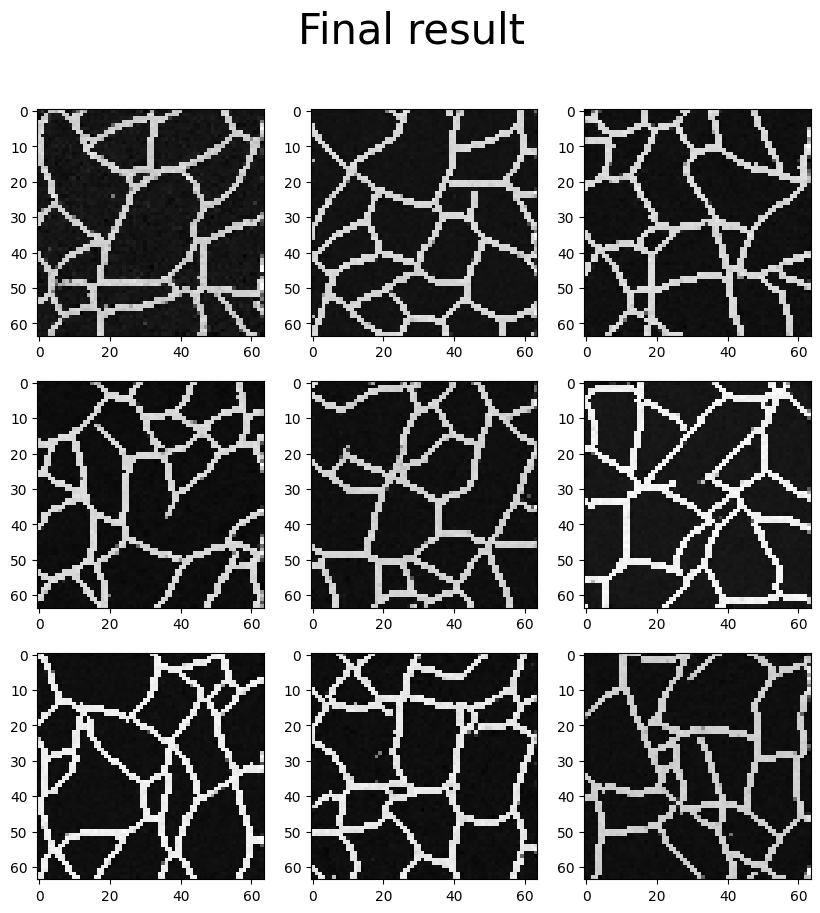

In [33]:
print("Generating new images")
fashion = 1
generated = generate_new_images(
        best_model,
        n_samples=9,
        device=device,
        gif_name="fashion.gif" if fashion else "mnist.gif"
    )
show_images(generated, "Final result")

In [ ]:
# from IPython.display import Image

# Image(open('fashion.gif' if fashion else 'mnist.gif','rb').read())